# Max likelihood

In [1]:
# imports
from importlib import reload

import pandas
import numpy as np
from scipy import special
import seaborn as sns
import mpmath
from matplotlib import pyplot as plt


# Generate a faux sample

## Let $E_{\rm max} = 10^{50}$ and $E_{\rm th} = 10^{40}$

In [2]:
gamma = -2.

In [3]:
NFRB = 100

In [4]:
lEmax = 50.
Emax = 10**lEmax

In [5]:
lEth = 40.
Eth = 10**lEth

In [6]:
norm = (Emax**(gamma+1) - Eth**(gamma+1))/(1+gamma)
norm

9.999999998999998e-41

In [7]:
randu = np.random.uniform(size=NFRB)

In [8]:
randE = (randu*(gamma+1)*norm + 10**(lEth*(gamma+1)))**(1/(1+gamma))

In [9]:
df = pandas.DataFrame()
df['E'] = randE
df['logE'] = np.log10(randE)

<AxesSubplot:xlabel='logE', ylabel='Count'>

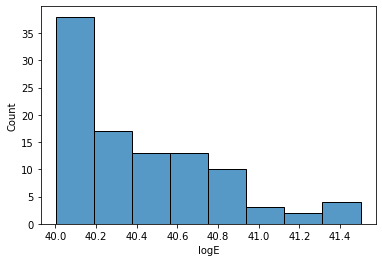

In [10]:
sns.histplot(data=df, x='logE')

# Max Likelihood Time!

## Methods

### We express the log-likelihood as 

## $\ln \mathcal{L} = - \int\limits_{E_{\rm th}}^{E_{\rm max}} p(E) dE + \sum\limits_{j=1}^N \ln p(E)$

### where $j$ is over all the $N$ FRBs and $p(E) = C E^\gamma$

## Likelihood terms

### This terms accounts for the total space explored.  It *decreases* with increasing Emax

In [11]:
def misses_term(C, Eth, Emax, gamma):
    return -C * (Emax**(gamma+1) - Eth**(gamma+1)) / (1+gamma)

### This term is simply proportional to the probability

In [12]:
def hit_term(Eval, C, gamma):
    NFRB = len(Eval)
    fterm = NFRB * np.log(C)
    sterm = gamma * np.sum(np.log(Eval))
    return fterm + sterm

In [13]:
def guess_C(gamma, Emax, Eth, NFRB):
    return NFRB * (gamma+1) / (Emax**(gamma+1) - Eth**(gamma+1))

## Test case $E_{max} = 10^{42}$

In [14]:
Emax = 1e42
#Eth = 1e40

In [15]:
guessC = guess_C(gamma, Emax, Eth, NFRB)
guessC

1.01010101010101e+42

In [16]:
logC = np.log10(guessC)
Cvals = 10**(np.linspace(logC-1, logC+1, 1000))

In [17]:
LL_C = misses_term(Cvals, Eth, Emax, gamma) + hit_term(df.E, Cvals, gamma)

<AxesSubplot:>

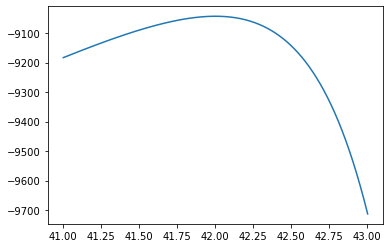

In [18]:
sns.lineplot(x=np.log10(Cvals), y=LL_C)

In [19]:
Cmax = Cvals[np.argmax(LL_C)]
Cmax

1.0077755194306342e+42

## Loop a bit

In [34]:
LLs = []
Emaxs = 10**(np.linspace(42., 47., 100))
Cmaxs = []

for Emax in Emaxs:
    guessC = guess_C(gamma, Emax, Eth, NFRB)
    logC = np.log10(guessC)
    Cvals = 10**(np.linspace(logC-1, logC+1, 1000))
    #
    misses = misses_term(Cvals, Eth, Emax, gamma) 
    hits = hit_term(df.E, Cvals, gamma)
    LL_C = misses + hits
    #print(guessC, Cvals[np.argmax(LL_C)])
    imax = np.argmax(LL_C)
    LLs.append(np.max(LL_C))
    Cmaxs.append(Cvals[imax])
    #print(misses[imax], hits[imax])
LLs = np.array(LLs)
Cmaxs = np.array(Cmaxs)

## Plot

Text(0, 0.5, ' $C$')

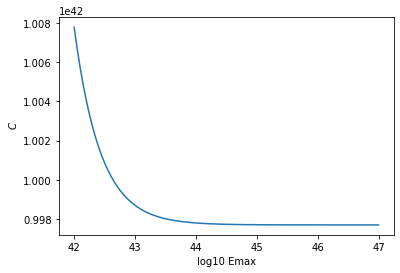

In [21]:
ax = sns.lineplot(x=np.log10(Emaxs), y=Cmaxs)
ax.set_xlabel('log10 Emax')
ax.set_ylabel(r' $C$')

Text(0, 0.5, ' $\\Delta \\, LL$')

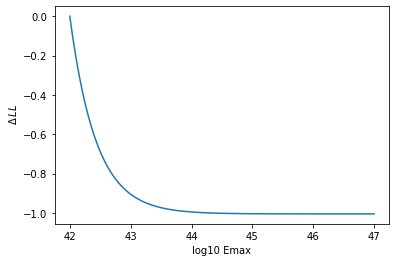

In [22]:
ax = sns.lineplot(x=np.log10(Emaxs), y=LLs - np.max(LLs))
ax.set_xlabel('log10 Emax')
ax.set_ylabel(r' $\Delta \, LL$')

### Clearly $\Delta LL$ is small (less than 1!) for all Emax values and there is no preference beyond 1e45.

### This follows our intuition..

----

# Alternative approach

## $\ln \mathcal{L} = \ln p_n(N) + \sum\limits_j^{N} \ln p_j(E)$

## with $p_j(E)$ normalized to unity

## As with the FRBs, we will assume we have another normlization constant (not $C$) that we can tune to given $N$ events.

## Therefore, we can always maximize $p_n(N)$

In [29]:
def norm_pE(Eth, Emax, gamma):
    norm = (Emax**(1+gamma) - Eth**(1+gamma))/(1+gamma)
    return norm

In [38]:
LLs2 = []
#Emaxs = 10**(np.linspace(42., 47., 100))
Cmaxs = []

for Emax in Emaxs:
    #
    norm = norm_pE(Eth, Emax, gamma)
    #print(guessC, Cvals[np.argmax(LL_C)])
    pE = df.E**gamma / norm
    #
    LLs2.append(np.sum(np.log(pE)))
LLs2 = np.array(LLs2)
#Cmaxs = np.array(Cmaxs)

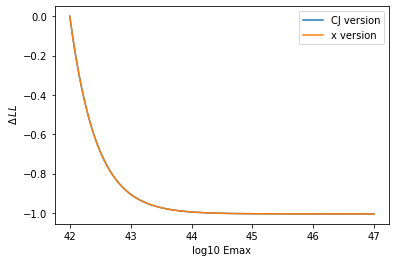

In [40]:
ax = sns.lineplot(x=np.log10(Emaxs), y=LLs2 - np.max(LLs2), label='CJ version')
ax = sns.lineplot(x=np.log10(Emaxs), y=LLs - np.max(LLs), label='x version')
ax.set_xlabel('log10 Emax')
ax.set_ylabel(r' $\Delta \, LL$')
ax.legend()

----

# Gamma function

In [61]:
def Gamma_misses_term(C, Eth, Emax, gamma):
    norm = Emax * float(mpmath.gammainc(gamma+1, a=Eth/Emax))
    return -C * norm

In [63]:
def Gamma_hit_term(Eval, C, gamma, Emax):
    NFRB = len(Eval)
    fterm = NFRB * np.log(C)
    sterm= np.sum(np.log((Eval/Emax)**(gamma) * np.exp(-Eval/Emax)))
    #import pdb; pdb.set_trace()
    return fterm + sterm

In [64]:
def Gamma_guess_C(gamma, Emax, Eth, NFRB):
    return NFRB / (Emax*float(mpmath.gammainc(gamma+1, a=Eth/Emax)))

In [65]:
gamma

-2.0

## Do it

In [66]:
LLsG = []
Emaxs = 10**(np.linspace(42., 47., 100))
Cmaxs = []

for Emax in Emaxs:
    guessC = Gamma_guess_C(gamma, Emax, Eth, NFRB)
    logC = np.log10(guessC)
    Cvals = 10**(np.linspace(logC-1, logC+1, 1000))
    #
    misses = Gamma_misses_term(Cvals, Eth, Emax, gamma) 
    hits = Gamma_hit_term(df.E, Cvals, gamma, Emax)
    LL_C = misses + hits
    #import pdb; pdb.set_trace()
    #print(guessC, Cvals[np.argmax(LL_C)])
    imax = np.argmax(LL_C)
    LLsG.append(np.max(LL_C))
    Cmaxs.append(Cvals[imax])
    #print(misses[imax], hits[imax])
LLsG = np.array(LLsG)
Cmaxs = np.array(Cmaxs)

In [67]:
LLsG[0:3]

array([-9042.9424586 , -9042.9579503 , -9042.98162901])

Text(0, 0.5, ' $C$')

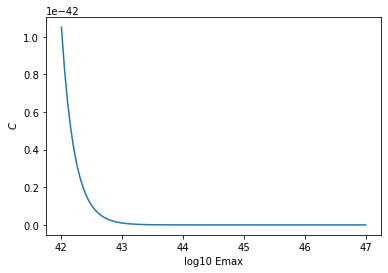

In [68]:
ax = sns.lineplot(x=np.log10(Emaxs), y=Cmaxs)
ax.set_xlabel('log10 Emax')
ax.set_ylabel(r' $C$')

In [69]:
LLsG

array([-9042.9424586 , -9042.9579503 , -9042.98162901, -9043.01159111,
       -9043.04623995, -9043.08424325, -9043.12449579, -9043.16608697,
       -9043.20827253, -9043.25044999, -9043.29213733, -9043.33295452,
       -9043.37260754, -9043.4108746 , -9043.44759428, -9043.48265528,
       -9043.51598775, -9043.54755572, -9043.57735079, -9043.60538669,
       -9043.63169466, -9043.65631959, -9043.67931676, -9043.70074915,
       -9043.72068507, -9043.73919642, -9043.75635702, -9043.77224145,
       -9043.78692399, -9043.80047785, -9043.81297449, -9043.82448321,
       -9043.83507073, -9043.84480094, -9043.85373476, -9043.86193002,
       -9043.86944139, -9043.87632041, -9043.88261554, -9043.88837217,
       -9043.89363275, -9043.89843688, -9043.90282145, -9043.90682073,
       -9043.9104665 , -9043.91378821, -9043.9168131 , -9043.91956633,
       -9043.92207111, -9043.92434882, -9043.92641914, -9043.92830017,
       -9043.93000851, -9043.93155943, -9043.9329669 , -9043.93424374,
      

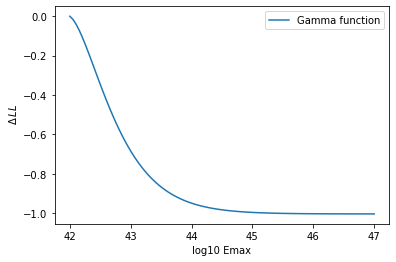

In [70]:
ax = sns.lineplot(x=np.log10(Emaxs), y=LLsG - np.max(LLsG), label='Gamma function')
#ax = sns.lineplot(x=np.log10(Emaxs), y=LLs - np.max(LLs), label='x version')
ax.set_xlabel('log10 Emax')
ax.set_ylabel(r' $\Delta \, LL$')
#ax.set_ylim(-1., 0.)
ax.legend()